In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import time
from numba import njit,guvectorize,float64
import scipy.optimize as opt
from matplotlib import pyplot as plt
import math
#Set
t = np.arange(1, 101)
NT = len(t)

In [2]:
#Parameters
fosslim = 6000 # Maximum cumulative extraction fossil fuels (GtC); denoted by CCum
tstep  = 5 # Years per Period
ifopt  = 0 # Indicator where optimized is 1 and base is 0

In [3]:
#Preferences

elasmu = 1.45 #  Elasticity of marginal utility of consumption
prstp = 0.015 #   Initial rate of social time preference per year 

#** Population and technology
gama  = 0.300 #   Capital elasticity in production function         /.300 /
pop0  = 7403   # Initial world population 2015 (millions)          /7403 /
popadj = 0.134 #  Growth rate to calibrate to 2050 pop projection  /0.134/
popasym = 11500 # Asymptotic population (millions)                 /11500/
dk  = 0.100 #     Depreciation rate on capital (per year)           /.100 /
q0  = 105.5 #     Initial world gross output 2015 (trill 2010 USD) /105.5/
k0  = 223 #     Initial capital value 2015 (trill 2010 USD)        /223  /
a0  = 5.115 #     Initial level of total factor productivity       /5.115/
ga0  = 0.076 #    Initial growth rate for TFP per 5 years          /0.076/
dela  = 0.005 #   Decline rate of TFP per 5 years                  /0.005/

#** Emissions parameters
gsigma1  = -0.0152 # Initial growth of sigma (per year)            /-0.0152/
dsig  = -0.001 #   Decline rate of decarbonization (per period)    /-0.001 /
eland0 = 2.6 #  Carbon emissions from land 2015 (GtCO2 per year)   / 2.6   /
deland = 0.115 # Decline rate of land emissions (per period)        / .115  /
e0 = 35.85 #    Industrial emissions 2015 (GtCO2 per year)       /35.85  /
miu0  = 0.03 #   Initial emissions control rate for base case 2015  /.03    /

#** Carbon cycle
#* Initial Conditions
mat0 = 851 #  Initial Concentration in atmosphere 2015 (GtC)       /851  /
mu0  = 460 #  Initial Concentration in upper strata 2015 (GtC)     /460  /
ml0  = 1740 #  Initial Concentration in lower strata 2015 (GtC)    /1740 /
mateq = 588 # mateq Equilibrium concentration atmosphere  (GtC)    /588  /
mueq  = 360 # mueq Equilibrium concentration in upper strata (GtC) /360  /
mleq = 1720 # mleq Equilibrium concentration in lower strata (GtC) /1720 /

#* Flow paramaters, denoted by Phi_ij in the model
b12  = 0.12 #    Carbon cycle transition matrix                     /.12  /
b23  = 0.007 #   Carbon cycle transition matrix                    /0.007/
#* These are for declaration and are defined later
b11  = None   # Carbon cycle transition matrix
b21  = None  # Carbon cycle transition matrix
b22  = None  # Carbon cycle transition matrix
b32  = None  # Carbon cycle transition matrix
b33  = None  # Carbon cycle transition matrix
sig0  = None  # Carbon intensity 2010 (kgCO2 per output 2005 USD 2010)

#** Climate model parameters
t2xco2  = 3.1 # Equilibrium temp impact (oC per doubling CO2)    / 3.1 /
fex0  = 0.5 #   2015 forcings of non-CO2 GHG (Wm-2)              / 0.5 /
fex1  = 1.0 #   2100 forcings of non-CO2 GHG (Wm-2)              / 1.0 /
tocean0  = 0.0068 # Initial lower stratum temp change (C from 1900) /.0068/
tatm0  = 0.85 #  Initial atmospheric temp change (C from 1900)    /0.85/
c1  = 0.1005 #     Climate equation coefficient for upper level  /0.1005/
c3  = 0.088 #     Transfer coefficient upper to lower stratum    /0.088/
c4  = 0.025 #     Transfer coefficient for lower level           /0.025/
fco22x  = 3.6813 # eta in the model; Eq.22 : Forcings of equilibrium CO2 doubling (Wm-2)   /3.6813 /

#** Climate damage parameters
a10  = 0 #     Initial damage intercept                         /0   /
a20  = None #     Initial damage quadratic term
a1  = 0 #      Damage intercept                                 /0   /
a2  = 0.00236 #      Damage quadratic term                     /0.00236/
a3  = 2.00 #      Damage exponent                              /2.00   /

#** Abatement cost
expcost2 = 2.6 # Theta2 in the model, Eq. 10 Exponent of control cost function             / 2.6  /
pback  = 550 #   Cost of backstop 2010$ per tCO2 2015          / 550  /
gback  = 0.025 #   Initial cost decline backstop cost per period / .025/
limmiu  = 1.2 #  Upper limit on control rate after 2150        / 1.2 /
tnopol  = 45 #  Period before which no emissions controls base  / 45   /
cprice0  = 2 # Initial base carbon price (2010$ per tCO2)      / 2    /
gcprice  = 0.02 # Growth rate of base carbon price per year     /.02  /

#** Scaling and inessential parameters
#* Note that these are unnecessary for the calculations
#* They ensure that MU of first period's consumption =1 and PV cons = PV utilty
scale1  = 0.0302455265681763 #    Multiplicative scaling coefficient           /0.0302455265681763 /
scale2  = -10993.704 #    Additive scaling coefficient       /-10993.704/;

In [4]:
#* Parameters for long-run consistency of carbon cycle 
#(Question)
b11 = 1 - b12
b21 = b12*mateq/mueq
b22 = 1 - b21 - b23
b32 = b23*mueq/mleq
b33 = 1 - b32

#* Further definitions of parameters
a20 = a2
sig0 = e0/(q0*(1-miu0)) #From Eq. 14
lam = fco22x/ t2xco2 #From Eq. 25

l = np.zeros(NT)
l[0] = pop0 #Labor force
al = np.zeros(NT) 
al[0] = a0
gsig = np.zeros(NT) 
gsig[0] = gsigma1
sigma = np.zeros(NT)
sigma[0]= sig0
ga = ga0 * np.exp(-dela*5*(t-1)) #TFP growth rate dynamics, Eq. 7
pbacktime = pback * (1-gback)**(t-1) #Backstop price
etree = eland0*(1-deland)**(t-1) #Emissions from deforestration
rr = 1/((1+prstp)**(tstep*(t-1))) #Eq. 3
#The following three equations define the exogenous radiative forcing; used in Eq. 23  
forcoth = np.full(NT,fex0)
forcoth[0:18] = forcoth[0:18] + (1/17)*(fex1-fex0)*(t[0:18]-1)
forcoth[18:NT] = forcoth[18:NT] + (fex1-fex0)
optlrsav = (dk + .004)/(dk + .004*elasmu + prstp)*gama #Optimal long-run savings rate used for transversality (Question)
cost1 = np.zeros(NT)
cumetree = np.zeros(NT)
cumetree[0] = 100
cpricebase = cprice0*(1+gcprice)**(5*(t-1)) 

In [5]:
@njit('(float64[:], int32)')
def InitializeLabor(il,iNT):
    for i in range(1,iNT):
        il[i] = il[i-1]*(popasym / il[i-1])**popadj

@njit('(float64[:], int32)')        
def InitializeTFP(ial,iNT):
    for i in range(1,iNT):
        ial[i] = ial[i-1]/(1-ga[i-1])
        
@njit('(float64[:], int32)')        
def InitializeGrowthSigma(igsig,iNT):
    for i in range(1,iNT):
        igsig[i] = igsig[i-1]*((1+dsig)**tstep)
        
@njit('(float64[:], float64[:],float64[:],int32)')        
def InitializeSigma(isigma,igsig,icost1,iNT):
    for i in range(1,iNT):
        isigma[i] =  isigma[i-1] * np.exp(igsig[i-1] * tstep)
        icost1[i] = pbacktime[i] * isigma[i]  / expcost2 /1000
        
@njit('(float64[:], int32)')        
def InitializeCarbonTree(icumetree,iNT):
    for i in range(1,iNT):
        icumetree[i] = icumetree[i-1] + etree[i-1]*(5/3.666)


In [6]:
"""
Functions of the model
"""

"""
First: Functions related to emissions of carbon and weather damages
"""

# Retuns the total carbon emissions; Eq. 18
@njit('float64(float64[:],int32)') 
def fE(iEIND,index):
    return iEIND[index] + etree[index]

#Eq.14: Determines the emission of carbon by industry EIND
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fEIND(iYGROSS, iMIU, isigma,index):
    return isigma[index] * iYGROSS[index] * (1 - iMIU[index])

#Cumulative industrial emission of carbon
@njit('float64(float64[:],float64[:],int32)') 
def fCCA(iCCA,iEIND,index):
    return iCCA[index-1] + iEIND[index-1] * 5 / 3.666

#Cumulative total carbon emission
@njit('float64(float64[:],float64[:],int32)')
def fCCATOT(iCCA,icumetree,index):
    return iCCA[index] + icumetree[index]

#Eq. 22: the dynamics of the radiative forcing
@njit('float64(float64[:],int32)')
def fFORC(iMAT,index):
    return fco22x * np.log(iMAT[index]/588.000)/np.log(2) + forcoth[index]

# Dynamics of Omega; Eq.9
@njit('float64(float64[:],int32)')
def fDAMFRAC(iTATM,index):
    return a1*iTATM[index] + a2*iTATM[index]**a3

#Calculate damages as a function of Gross industrial production; Eq.8 
@njit('float64(float64[:],float64[:],int32)')
def fDAMAGES(iYGROSS,iDAMFRAC,index):
    return iYGROSS[index] * iDAMFRAC[index]

#Dynamics of Lambda; Eq. 10 - cost of the reudction of carbon emission (Abatement cost)
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fABATECOST(iYGROSS,iMIU,icost1,index):
    return iYGROSS[index] * icost1[index] * iMIU[index]**expcost2

#Marginal Abatement cost
@njit('float64(float64[:],int32)')
def fMCABATE(iMIU,index):
    return pbacktime[index] * iMIU[index]**(expcost2-1)

#Price of carbon reduction
@njit('float64(float64[:],int32)')
def fCPRICE(iMIU,index):
    return pbacktime[index] * (iMIU[index])**(expcost2-1)

#Eq. 19: Dynamics of the carbon concentration in the atmosphere
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fMAT(iMAT,iMU,iE,index):
    if(index == 0):
        return mat0
    else:
        return iMAT[index-1]*b11 + iMU[index-1]*b21 + iE[index-1] * 5 / 3.666

#Eq. 21: Dynamics of the carbon concentration in the ocean LOW level
@njit('float64(float64[:],float64[:],int32)') 
def fML(iML,iMU,index):
    if(index == 0):
        return ml0
    else:
        return iML[index-1] * b33  + iMU[index-1] * b23

#Eq. 20: Dynamics of the carbon concentration in the ocean UP level
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fMU(iMAT,iMU,iML,index):
    if(index == 0):
        return mu0
    else:
        return iMAT[index-1]*b12 + iMU[index-1]*b22 + iML[index-1]*b32

#Eq. 23: Dynamics of the atmospheric temperature
@njit('float64(float64[:],float64[:],float64[:],int32)') 
def fTATM(iTATM,iFORC,iTOCEAN,index):
    if(index == 0):
        return tatm0
    else:
        return iTATM[index-1] + c1 * (iFORC[index] - (fco22x/t2xco2) * iTATM[index-1] - c3 * (iTATM[index-1] - iTOCEAN[index-1]))

#Eq. 24: Dynamics of the ocean temperature
@njit('float64(float64[:],float64[:],int32)')
def fTOCEAN(iTATM,iTOCEAN,index):
    if(index == 0):
        return tocean0
    else:
        return iTOCEAN[index-1] + c4 * (iTATM[index-1] - iTOCEAN[index-1])

"""
Second: Function related to economic variables
"""

#The total production without climate losses denoted previously by YGROSS
@njit('float64(float64[:],float64[:],float64[:],int32)')
def fYGROSS(ial,il,iK,index):
    return ial[index] * ((il[index]/1000)**(1-gama)) * iK[index]**gama

#The production under the climate damages cost
@njit('float64(float64[:],float64[:],int32)')
def fYNET(iYGROSS, iDAMFRAC, index):
    return iYGROSS[index] * (1 - iDAMFRAC[index])

#Production after abatement cost
@njit('float64(float64[:],float64[:],int32)')
def fY(iYNET,iABATECOST,index):
    return iYNET[index] - iABATECOST[index]

#Consumption Eq. 11
@njit('float64(float64[:],float64[:],int32)')
def fC(iY,iI,index):
    return iY[index] - iI[index]

#Per capita consumption, Eq. 12
@njit('float64(float64[:],float64[:],int32)')
def fCPC(iC,il,index):
    return 1000 * iC[index] / il[index]

#Saving policy: investment
@njit('float64(float64[:],float64[:],int32)')
def fI(iS,iY,index):
    return iS[index] * iY[index] 

#Capital dynamics Eq. 13
@njit('float64(float64[:],float64[:],int32)')
def fK(iK,iI,index):
    if(index == 0):
        return k0
    else:
        return (1-dk)**tstep * iK[index-1] + tstep * iI[index-1]

#Interest rate equation; Eq. 26 added in personal notes
@njit('float64(float64[:],int32)')
def fRI(iCPC,index):
    return (1 + prstp) * (iCPC[index+1]/iCPC[index])**(elasmu/tstep) - 1

#Periodic utility: A form of Eq. 2
@njit('float64(float64[:],float64[:],int32)')
def fCEMUTOTPER(iPERIODU,il,index):
    return iPERIODU[index] * il[index] * rr[index]

#The term between brackets in Eq. 2
@njit('float64(float64[:],float64[:],int32)')
def fPERIODU(iC,il,index):
    return ((iC[index]*1000/il[index])**(1-elasmu) - 1) / (1 - elasmu) - 1

#utility function
@guvectorize([(float64[:], float64[:])], '(n), (m)')
def fUTILITY(iCEMUTOTPER, resUtility):
    resUtility[0] = tstep * scale1 * np.sum(iCEMUTOTPER) + scale2


In [7]:

"""
In this part we implement the objective function
"""

# * Control rate limits
MIU_lo = np.full(NT,0.01)
MIU_up = np.full(NT,limmiu)
MIU_up[0:29] = 1
MIU_lo[0] = miu0
MIU_up[0] = miu0
MIU_lo[MIU_lo==MIU_up] = 0.99999*MIU_lo[MIU_lo==MIU_up]
bnds1=[]
for i in range(NT):
    bnds1.append((MIU_lo[i],MIU_up[i]))
# * Control variables
lag10 = t > NT - 10
S_lo = np.full(NT,1e-1)
S_lo[lag10] = optlrsav
S_up = np.full(NT,0.9)
S_up[lag10] = optlrsav
S_lo[S_lo==S_up] = 0.99999*S_lo[S_lo==S_up]
bnds2=[]
for i in range(NT):
    bnds2.append((S_lo[i],S_up[i]))
    
# Arbitrary starting values for the control variables:
S_start = np.full(NT,0.2)
S_start[S_start < S_lo] = S_lo[S_start < S_lo]
S_start[S_start > S_up] = S_lo[S_start > S_up]
MIU_start = 0.99*MIU_up
MIU_start[MIU_start < MIU_lo] = MIU_lo[MIU_start < MIU_lo]
MIU_start[MIU_start > MIU_up] = MIU_up[MIU_start > MIU_up]

K = np.zeros(NT)
YGROSS = np.zeros(NT)
EIND = np.zeros(NT)
E = np.zeros(NT)
CCA = np.zeros(NT)
CCATOT = np.zeros(NT)
MAT = np.zeros(NT)
ML = np.zeros(NT)
MU = np.zeros(NT)
FORC = np.zeros(NT)
TATM = np.zeros(NT)
TOCEAN = np.zeros(NT)
DAMFRAC = np.zeros(NT)
DAMAGES = np.zeros(NT)
ABATECOST = np.zeros(NT)
MCABATE = np.zeros(NT)
CPRICE = np.zeros(NT)
YNET = np.zeros(NT)
Y = np.zeros(NT)
I = np.zeros(NT)
C = np.zeros(NT)
CPC = np.zeros(NT)
RI = np.zeros(NT)
PERIODU = np.zeros(NT)
CEMUTOTPER = np.zeros(NT)

In [8]:
#The objective function
#It returns the utility as scalar
def fOBJ(x,sign,iI,iK,ial,il,iYGROSS,isigma,iEIND,iE,iCCA,iCCATOT,icumetree,iMAT,iMU,iML,iFORC,iTATM,iTOCEAN,iDAMFRAC,iDAMAGES,iABATECOST,icost1,iMCABATE,
         iCPRICE,iYNET,iY,iC,iCPC,iPERIODU,iCEMUTOTPER,iRI,iNT):
    
    iMIU = x[0:NT]
    iS = x[NT:(2*NT)]
    
    for i in range(iNT):
        iK[i] = fK(iK,iI,i)
        iYGROSS[i] = fYGROSS(ial,il,iK,i)
        iEIND[i] = fEIND(iYGROSS, iMIU, isigma,i)
        iE[i] = fE(iEIND,i)
        iCCA[i] = fCCA(iCCA,iEIND,i)
        iCCATOT[i] = fCCATOT(iCCA,icumetree,i)
        iMAT[i] = fMAT(iMAT,iMU,iE,i)
        iML[i] = fML(iML,iMU,i)
        iMU[i] = fMU(iMAT,iMU,iML,i)
        iFORC[i] = fFORC(iMAT,i)
        iTATM[i] = fTATM(iTATM,iFORC,iTOCEAN,i)
        iTOCEAN[i] = fTOCEAN(iTATM,iTOCEAN,i)
        iDAMFRAC[i] = fDAMFRAC(iTATM,i)
        iDAMAGES[i] = fDAMAGES(iYGROSS,iDAMFRAC,i)
        iABATECOST[i] = fABATECOST(iYGROSS,iMIU,icost1,i)
        iMCABATE[i] = fMCABATE(iMIU,i)
        iCPRICE[i] = fCPRICE(iMIU,i)
        iYNET[i] = fYNET(iYGROSS, iDAMFRAC, i)
        iY[i] = fY(iYNET,iABATECOST,i)
        iI[i] = fI(iS,iY,i)
        iC[i] = fC(iY,iI,i)
        iCPC[i] = fCPC(iC,il,i)
        iPERIODU[i] = fPERIODU(iC,il,i)
        iCEMUTOTPER[i] = fCEMUTOTPER(iPERIODU,il,i)
        iRI = fRI(iCPC,i)
        
    resUtility = np.zeros(1)
    fUTILITY(iCEMUTOTPER, resUtility)
    
    return sign*resUtility[0]

In [9]:
InitializeLabor(l,NT)
InitializeTFP(al,NT)
InitializeGrowthSigma(gsig,NT)
InitializeSigma(sigma,gsig,cost1,NT)
InitializeCarbonTree(cumetree,NT)

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
tfd = tfp.distributions

# Configuration parameters for the whole setup
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 1000
eps = np.finfo(np.float32).eps.item()  # Smallest number such that 1.0 + eps != 1.0

In [11]:
class OPTIM(object):
    def __init__(self):
        super(OPTIM, self).__init__()
    
    def step(self, action):
        global x
        
        miu = action[0]
        s = action[1]
        x[steps%100] = miu
        x[steps%100+100] = s
        #obs_ = np.array([miu,s])
        #obs_ = np.array([miu,s,steps+1])
        reward = fOBJ(x,1,I,K,al,l,YGROSS,sigma,EIND,E,CCA,CCATOT,cumetree,MAT,MU,ML,FORC,
                      TATM,TOCEAN,DAMFRAC,DAMAGES,ABATECOST,cost1,MCABATE,CPRICE,YNET,Y,C,CPC,PERIODU,CEMUTOTPER,RI,NT)
        R = reward / 4500
        done = bool(R > 1 or miu == np.nan)
        #if done == True:
            #if reward > 4500:
             #   R = 2
            #else:
            #    R = 1
        #else:
            #R = 0
        #if steps == 99:
        #print(R)
        return x, R, done
        
    def reset(self):
        return np.concatenate([MIU_start,S_start])
        #return np.array([MIU_start[0],S_start[0],0])


In [12]:
env = OPTIM()
num_inputs = 200
num_hidden = 512

In [13]:
inputs = layers.Input(shape=(num_inputs,))
common = layers.Dense(num_hidden, activation="relu")(inputs)
critic = layers.Dense(1)(common)
#4 for 2 miu and 2 sigmas of 2 iid normal distributions
norm_par = layers.Dense(4)(common)

model = keras.Model(inputs=inputs, outputs=[norm_par, critic])

In [14]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.8)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0
Reward = []
epi = []

while True:  # Run until solved
    state = env.reset()
    x = env.reset()
    episode_reward = 0
    
    with tf.GradientTape() as tape:
        steps = 0
        for timestep in range(1, max_steps_per_episode):
            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)
            # Predict action probabilities and estimated future rewards
            # from environment state
            norm_par, critic_value = model(state)
            norm_dist = tfd.MultivariateNormalDiag(loc=[norm_par[0, 0], norm_par[0, 1]], 
                                                   scale_diag=[tf.nn.softplus(norm_par[0, 2])+1e-5, 
                                                               tf.nn.softplus(norm_par[0, 3])+1e-5])
            
            # Sample action from action probability distribution
            action = tf.squeeze(np.absolute(norm_dist.sample(1)), axis=0)
            action = tf.clip_by_value(tf.expand_dims(action, 1), tf.constant([MIU_lo[steps%100], S_lo[steps%100]], shape = [2,1], dtype=tf.float32),
                                      tf.constant([MIU_up[steps%100], S_up[steps%100]], shape = [2,1], dtype=tf.float32))                
                
            tflog = tf.math.log(norm_dist.prob(tf.squeeze(action))+1)
                
            critic_value_history.append(critic_value[0, 0])
            action_probs_history.append(tflog)

            # Apply the sampled action in our environment
            state, reward, done = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward
            
            #if timestep == max_steps_per_episode-1:
                #print("episode_count", episode_count)
                #print("norm_par", norm_par)
                #print("critic_value", critic_value)
                ##print("action", action)
                #print("tflog", tflog)
            #print(state)
            
            steps += 1
            
            if done:
                break
            
            if timestep == max_steps_per_episode-1:
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    template = "running reward: {:.2f}, reward: {:.2f} at episode {}"
    print(template.format(running_reward, reward, episode_count))
    
    Reward.append(reward)
    epi.append(episode_count)
    
    if reward > 1:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break
        
    if episode_count == 1000:  
        print("Reached episode {}!".format(episode_count))
        break

running reward: 6.93, reward: 0.15 at episode 1
running reward: 9.94, reward: 0.34 at episode 2
running reward: 0.47, reward: 0.04 at episode 3
running reward: 2.07, reward: 0.17 at episode 4
running reward: -10.63, reward: 0.22 at episode 5
running reward: -34.63, reward: -0.51 at episode 6
running reward: -75.68, reward: -1.16 at episode 7
running reward: -121.78, reward: -1.13 at episode 8
running reward: -149.42, reward: -0.91 at episode 9
running reward: -113.65, reward: 0.55 at episode 10
running reward: -74.49, reward: 0.75 at episode 11
running reward: -31.09, reward: 0.78 at episode 12
running reward: 14.50, reward: 0.95 at episode 13
running reward: 54.18, reward: 0.89 at episode 14
running reward: 93.63, reward: 0.81 at episode 15
running reward: 119.22, reward: 0.27 at episode 16
running reward: 49.26, reward: -1.31 at episode 17
running reward: -17.65, reward: -1.31 at episode 18
running reward: -82.27, reward: -1.34 at episode 19
running reward: -143.80, reward: -1.34 at 

running reward: -1311.93, reward: -1.34 at episode 154
running reward: -1311.99, reward: -1.34 at episode 155
running reward: -1312.05, reward: -1.34 at episode 156
running reward: -1312.10, reward: -1.34 at episode 157
running reward: -1312.15, reward: -1.34 at episode 158
running reward: -1312.20, reward: -1.34 at episode 159
running reward: -1312.25, reward: -1.34 at episode 160
running reward: -1312.29, reward: -1.34 at episode 161
running reward: -1312.34, reward: -1.34 at episode 162
running reward: -1312.38, reward: -1.34 at episode 163
running reward: -1312.41, reward: -1.34 at episode 164
running reward: -1312.45, reward: -1.34 at episode 165
running reward: -1312.49, reward: -1.34 at episode 166
running reward: -1312.52, reward: -1.34 at episode 167
running reward: -1312.55, reward: -1.34 at episode 168
running reward: -1312.58, reward: -1.34 at episode 169
running reward: -1312.61, reward: -1.34 at episode 170
running reward: -1312.63, reward: -1.34 at episode 171
running re

KeyboardInterrupt: 

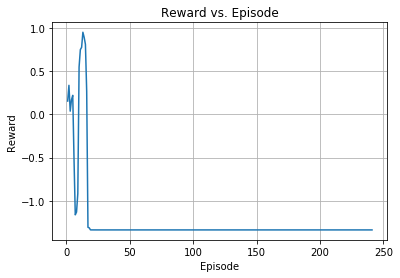

In [15]:
fig, ax = plt.subplots()
ax.plot(epi, Reward)

ax.set(xlabel='Episode', ylabel='Reward',
       title='Reward vs. Episode')
ax.grid()
plt.show()